In [1185]:
# Import required libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from model import DenseNet121, CLASS_NAMES  # Importing the model and class names from model.py


In [1186]:
import sys
print(sys.executable)


C:\Users\zafer\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe


In [1187]:
# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

        # Hooks to save activations and gradients
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
    # Compute the weights
        weights = self.gradients.mean(dim=[0, 2, 3]).to(self.activation.device)  # Ensure weights are on the same device as activation
        activation = self.activation.squeeze(0).detach()

    # Initialize the heatmap on the correct device
        heatmap = torch.zeros(activation.shape[1:], device=activation.device)

    # Compute the weighted sum of activations
        for i, w in enumerate(weights):
            heatmap += w * activation[i]

    # Apply ReLU to remove negative values
        heatmap = torch.clamp(heatmap, min=0)
        return heatmap.cpu().numpy()  # Move to CPU for visualization


In [1188]:
 # Path to the pre-trained model checkpoint
N_CLASSES = len(CLASS_NAMES)  # Number of classes

# Initialize the model
model = DenseNet121(N_CLASSES).cuda()

# Load the checkpoint
checkpoint = torch.load(CKPT_PATH)

# Adjust state_dict to fix keys
state_dict = checkpoint["state_dict"]
new_state_dict = {}
for k, v in state_dict.items():
    # Remove 'module.' prefix if present
    new_key = k.replace("module.", "")
    # Replace 'norm.1' with 'norm1', 'conv.1' with 'conv1', etc.
    new_key = new_key.replace(".1", "1").replace(".2", "2").replace(".3", "3")
    new_state_dict[new_key] = v

# Load the adjusted state_dict
model.load_state_dict(new_state_dict)

# Set model to evaluation mode
model.eval()

print("Model loaded successfully with adjusted state_dict!")


C:\Users\zafer\AppData\Local\Temp\ipykernel_39048\2010743767.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CKPT_PATH)


Model loaded successfully with adjusted state_dict!


In [1189]:
# Identify the target layer for Grad-CAM
target_layer = model.densenet121.features[-1]  # Last convolutional layer of DenseNet121
grad_cam = GradCAM(model, target_layer)


In [1190]:
import os
import random

# Paths
test_list_path = "ChestX-ray14/labels/test_list.txt"
image_dir = "C:/Users/zafer/OneDrive/Masaüstü/Dev/cnn-in-nih14-old/dataset/images-1024/images-1024"

# Load test_list.txt and pick a random image
with open(test_list_path, "r") as f:
    lines = f.readlines()

# Extract image IDs
image_ids = [line.split()[0] for line in lines]
random_image_id = random.choice(image_ids)

# Full image path
random_image_path = os.path.join(image_dir, random_image_id)

print(f"Selected random image: {random_image_path}")

# Load test_list.txt and find the labels for the selected image
with open(test_list_path, "r") as f:
    lines = f.readlines()

# Find the corresponding line for the selected image
selected_line = next(line for line in lines if random_image_id in line)

# Extract binary labels for the diseases
binary_labels = list(map(int, selected_line.split()[1:]))

# Map binary labels to disease names
detected_diseases = [CLASS_NAMES[i] for i, label in enumerate(binary_labels) if label == 1]

print(f"Detected diseases for the image '{random_image_id}': {detected_diseases}")


Selected random image: C:/Users/zafer/OneDrive/Masaüstü/Dev/cnn-in-nih14-old/dataset/images-1024/images-1024\00028582_010.png
Detected diseases for the image '00028582_010.png': ['Mass', 'Pneumothorax']


In [1191]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224x224
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Load and preprocess the image

img = Image.open(random_image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).cuda()  # Add batch dimension and move to GPU


In [1192]:
# Perform forward pass
output = model(input_tensor)

# Select a target class for visualization
target_class = 1  #[ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                  #"Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
                  
model.zero_grad()  # Clear gradients

output[0, target_class].backward()  # Perform backward pass for the target class


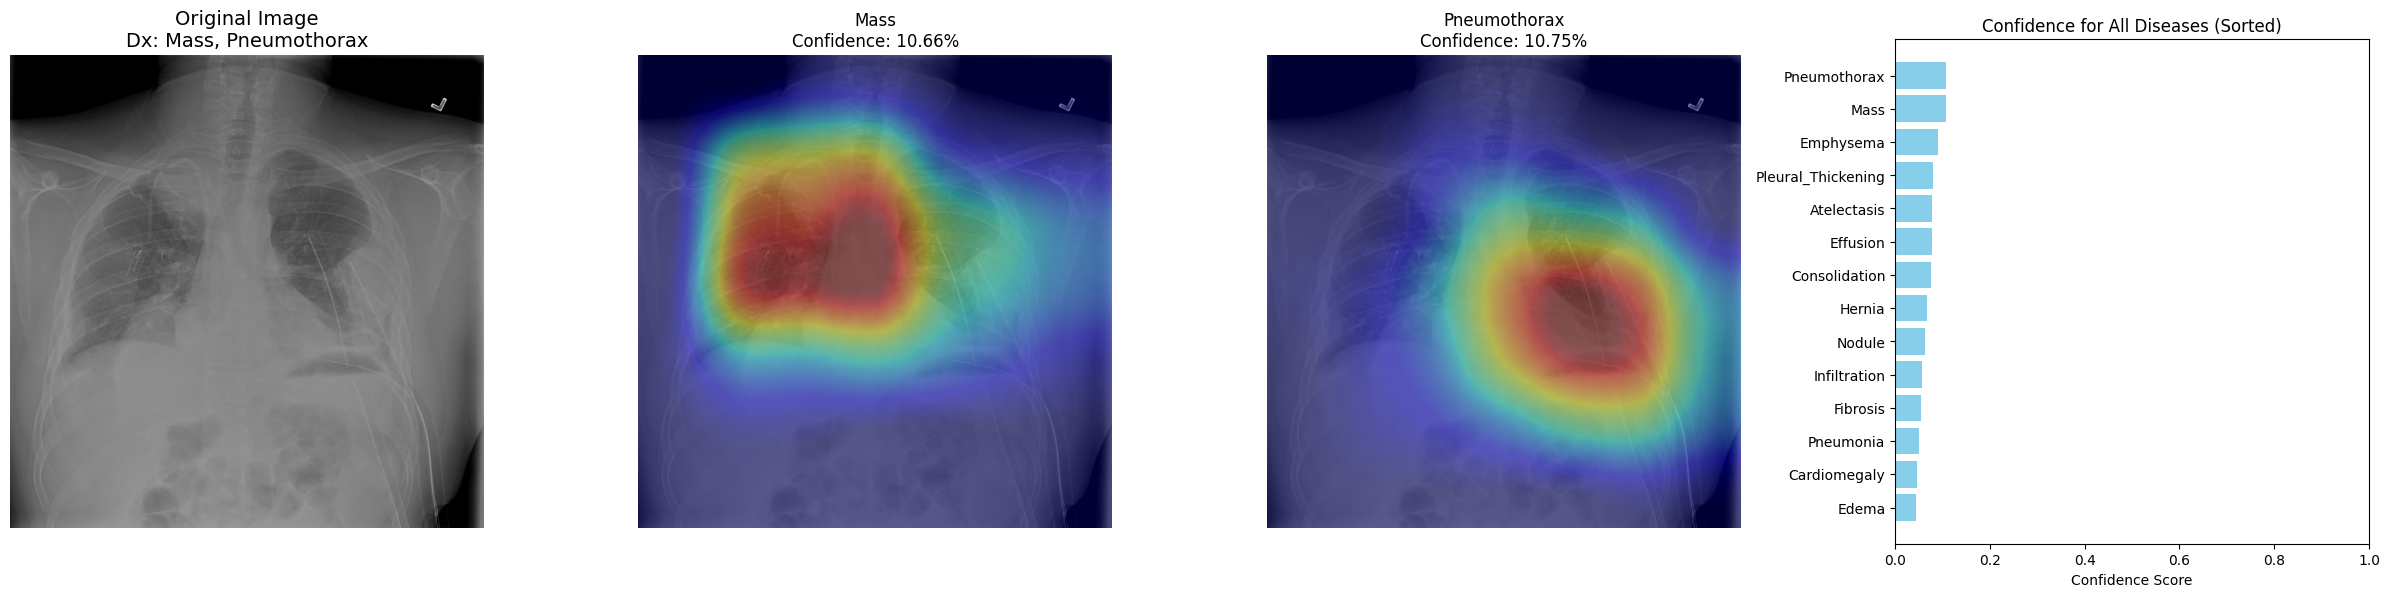

In [1193]:
# Generate Grad-CAM visualizations for each detected disease
if detected_diseases:
    # Get raw model output (logits) and apply softmax only for confidence scores
    logits = model(input_tensor)  # Raw output from the model
    confidence_scores = logits.softmax(dim=1).detach().cpu().numpy().flatten()

    # Sort diseases and scores for the bar chart (high to low)
    sorted_indices = confidence_scores.argsort()[::-1]  # Sort in descending order
    sorted_scores = confidence_scores[sorted_indices]
    sorted_diseases = [CLASS_NAMES[i] for i in sorted_indices]

    # Create subplots in a single row + 1 for the bar chart
    fig, axes = plt.subplots(1, len(detected_diseases) + 2, figsize=(6 * (len(detected_diseases) + 2), 6))

    # Plot the original image in the first column with detected illnesses in header
    detected_text = ", ".join(detected_diseases)
    axes[0].imshow(img)
    axes[0].set_title(f"Original Image\nDx: {detected_text}", fontsize=14)
    axes[0].axis("off")

    # Grad-CAM overlays for each detected disease
    for idx, disease in enumerate(detected_diseases):
        target_class = CLASS_NAMES.index(disease)

        # Recalculate Grad-CAM for the specific target class
        model.zero_grad()  # Clear existing gradients
        logits[0, target_class].backward(retain_graph=True)  # Retain the computational graph
        heatmap = grad_cam.generate_heatmap(target_class)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max()

        # Resize and blend heatmap
        heatmap_resized = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(img.size, Image.BICUBIC)
        heatmap_array = np.array(heatmap_resized)
        heatmap_overlay = np.array(img).astype(np.float32)
        heatmap_overlay = (heatmap_overlay * 0.6 + plt.cm.jet(heatmap_array / 255.0)[:, :, :3] * 255 * 0.4).astype(np.uint8)

        # Plot Grad-CAM overlay with confidence percentage
        axes[idx + 1].imshow(heatmap_overlay)
        axes[idx + 1].set_title(f"{disease}\nConfidence: {confidence_scores[target_class]:.2%}")
        axes[idx + 1].axis("off")

    # Add bar chart of sorted confidence scores for all 14 diseases
    axes[-1].barh(sorted_diseases, sorted_scores, color="skyblue")
    axes[-1].set_xlim(0, 1)
    axes[-1].set_xlabel("Confidence Score")
    axes[-1].set_title("Confidence for All Diseases (Sorted)")
    axes[-1].invert_yaxis()  # Flip to display highest confidence at the top

    plt.tight_layout()
    plt.show()
else:
    print(f"No detected diseases for the image '{random_image_id}'.")


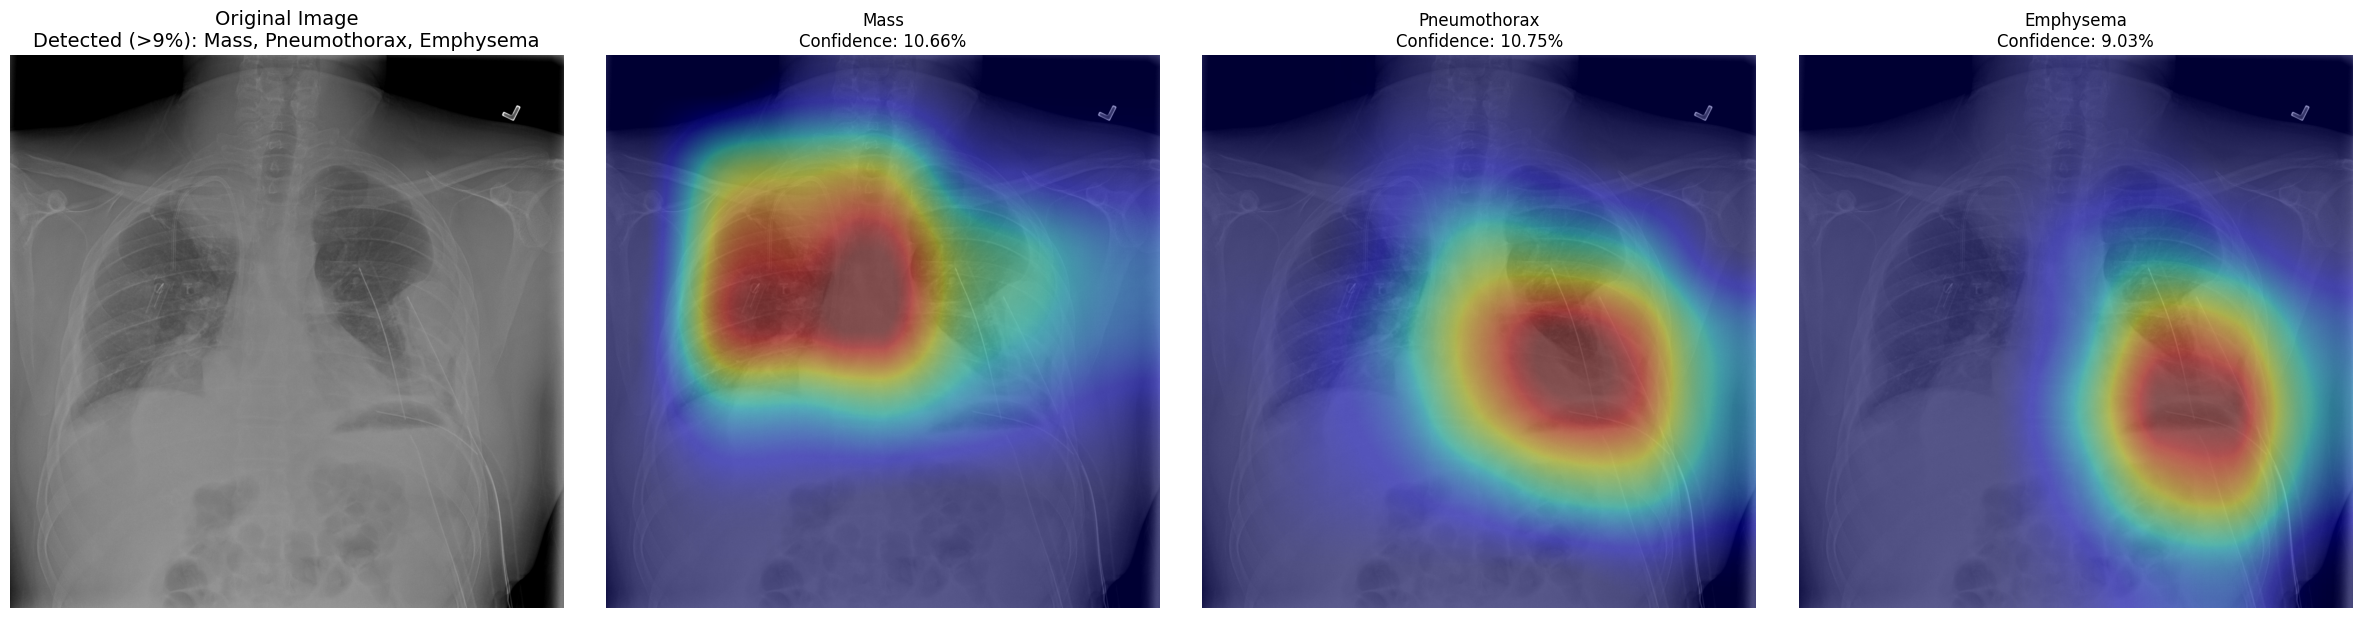

In [1194]:
# Generate Grad-CAM visualizations for detected diseases with confidence > 12%
THRESHOLD = 0.09  # Confidence threshold (12%)

if detected_diseases:
    # Get raw model output (logits) and apply softmax for confidence scores
    logits = model(input_tensor)  # Raw output from the model
    confidence_scores = logits.softmax(dim=1).detach().cpu().numpy().flatten()

    # Filter diseases based on confidence threshold
    high_confidence_indices = [i for i in range(len(CLASS_NAMES)) if confidence_scores[i] > THRESHOLD]
    high_confidence_scores = [confidence_scores[i] for i in high_confidence_indices]
    high_confidence_diseases = [CLASS_NAMES[i] for i in high_confidence_indices]

    if high_confidence_diseases:
        # Create subplots for the original image and filtered Grad-CAM overlays
        fig, axes = plt.subplots(1, len(high_confidence_diseases) + 1, figsize=(6 * (len(high_confidence_diseases) + 1), 6))

        # Plot the original image in the first column with detected illnesses in header
        detected_text = ", ".join(high_confidence_diseases)
        axes[0].imshow(img)
        axes[0].set_title(f"Original Image\nDetected (>{THRESHOLD*100:.0f}%): {detected_text}", fontsize=14)
        axes[0].axis("off")

        # Grad-CAM overlays for each high-confidence disease
        for idx, disease in enumerate(high_confidence_diseases):
            target_class = CLASS_NAMES.index(disease)

            # Recalculate Grad-CAM for the specific target class
            model.zero_grad()  # Clear existing gradients
            logits[0, target_class].backward(retain_graph=True)  # Retain the computational graph
            heatmap = grad_cam.generate_heatmap(target_class)
            heatmap = np.maximum(heatmap, 0)
            heatmap /= heatmap.max()

            # Resize and blend heatmap
            heatmap_resized = Image.fromarray((heatmap * 255).astype(np.uint8)).resize(img.size, Image.BICUBIC)
            heatmap_array = np.array(heatmap_resized)
            heatmap_overlay = np.array(img).astype(np.float32)
            heatmap_overlay = (heatmap_overlay * 0.6 + plt.cm.jet(heatmap_array / 255.0)[:, :, :3] * 255 * 0.4).astype(np.uint8)

            # Plot Grad-CAM overlay with confidence percentage
            axes[idx + 1].imshow(heatmap_overlay)
            axes[idx + 1].set_title(f"{disease}\nConfidence: {high_confidence_scores[idx]:.2%}")
            axes[idx + 1].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print(f"No diseases detected with confidence > {THRESHOLD*100:.0f}% for the image '{random_image_id}'.")
else:
    print(f"No detected diseases for the image '{random_image_id}'.")
